# Регрессор, для определения положения изображения в мозгу

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
import os
import numpy as np
import nibabel as nib
from nilearn import image
import matplotlib.pyplot as plt

In [2]:
path = r'F:\!наука\stroke\Lesions\Lesions'
stroke_types = os.listdir(path)
X = []
Y = []
for folder in stroke_types:
    for patient in os.listdir(f'{path}\{folder}'):
        img = nib.load(f'{path}\{folder}\{patient}\dwi.nii.gz')
        if len(img.shape) == 4:
            img = image.index_img(img, 0)
            img_data = img.get_fdata()
            aff = img.affine
            for i in range(img.shape[2]):
                Y.append(round((aff @ np.array([0, 0, i, 1]))[2]))
                X.append(img_data[:, :, i])


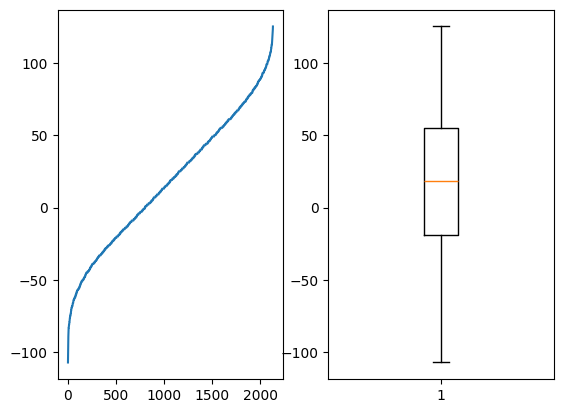

In [3]:
#выбросов не наблюдается
fig, ax = plt.subplots(1, 2)
ax[0].plot(sorted(Y))
ax[1].boxplot(Y)
plt.show()

In [23]:
X = np.array(X)
# нормализуем Y, чтобы не было отрицательных значений
Y -= np.min(Y)
Y = np.array(Y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [24]:
#Конвертируем в тензоры

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

In [25]:
# создаём датасеты и лоадеры

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#### Модель

Сейчас пробуем достаточно простую:

- два свёрточных слоя
- два пулинговых
- два полносвязных

может, добавить ещё дропаут??

В качестве активации используем ReLU


In [17]:
import torch.nn as nn

class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        
        #изображение чб, так что на вход 1 канал. Попробуем применить 16 фильтров 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # получает на вход 16 каналов и выдаёт 32
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        #дропнем ещё 20% фич
        self.drop = nn.Dropout2d(p=0.2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=62, kernel_size=3, padding=1, stride=1)
        # Наша картинка размером 256х256 и к ней 2 раза применяется пулинг с ядром размера 2
        # 256/2/2/2 = 32. Значит, наш тензор признаков будет 64х64 а мы нагенерировали их 64
        self.fc1 = nn.Linear(in_features=32 * 32 * 64, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=1)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.pool(x)

        x = nn.functional.dropout(self.drop(x), training=self.training)

        x = x.view(-1, 32 * 32 * 64)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x


#### Тренировочка

В качестве лосса будем использовать MSE, в качестве оптимизатора - Adam

In [31]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

model = CNNRegressor().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
    for i, (inputs, targets) in enumerate(train_loader):
        #обнуляем градиенты
        optimizer.zero_grad()

        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        #выведем статистику
        if (i+1)%10 == 0:
            print(f'Epoch: {epoch+1}/10, Step: {i+1}/{len(train_loader)}, Loss: {loss.item() :.2f}')


In [27]:
#ну и на тесте
with torch.no_grad(): #тут нам градиент не нужен, не тратим на него время
    total_loss = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
    mean_loss = total_loss / len(test_loader)
    print(f'Test Loss: {mean_loss:.4f}')

Test Loss: 503.1458


In [28]:
outputs.T

tensor([[ 54.7409, 142.3506,  82.0680,  43.1481, 220.6697, 117.2217,  98.8073,
         132.0001, 137.4942, 122.0130,  77.6805]])

In [29]:
targets.T

tensor([[ 76., 164., 112.,  51., 162., 130.,  51., 158., 167., 120.,  26.]])